In [1]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import utils
from PIL import Image
import torch.nn as nn
import pandas as pd
import numpy as np
import torch
import copy
import os

In [2]:
class EyeDataset(Dataset):
    def __init__(self, csv_path, root_dir, transform=None):
        """
        Params:
            csv_path (str): path to the csv file containing images paths and labels
            root_dir (str): path to the folder containing the images
            transform (callable, optional): optional transformation to the data
        """
        data = pd.read_csv(csv_path)
        
        self.img_path = np.array(data['Paths'],str)
        self.label = np.array(data['Label'],int)
        
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_path)
                         
    
    def __getitem__(self, idx):
        """
        This methods loads the next sample form the dataset using the name of the image from the
        dataset. The image is loaded as PIL image and then converted into RGB as there are different
        types of formats in the images, this allows us to treat them all equally.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Creates path to the images from working directory, in this case 
        # e.g.: .\Eyes_DataSet\Data\s001_0001_0_0_0_0_0_01.png 
        img_name = os.path.join(self.root_dir, self.img_path[idx])
        img = Image.open(img_name)
        img = img.convert('RGB') # Converts to RGB values the image
        label = self.label[idx]
        
        sample = {'image': img, 'label': label}
        
        if self.transform:
            sample['image'] = self.transform(sample['image'])
            
        return sample
    
    
    
       
def image_grid(imgs, rows, cols, dims=(64,64)):
    """
    Params:
        imgs (list of PIL images): Images to be printed
        rows (int): rows of the grid
        cols (int): cols of the grid
        dims (tuple): dimensions of the images to be displayed    
        
    Output:
        grid (grid): returns a grid with the images
        
    Example:
        buffer = []
        for img in images:
            img = (255*img).cpu().detach().numpy().astype(np.uint8)
            img = np.transpose(img, (1, 2, 0)) # 3 28,128 -> 128, 128, 3
            pil_image = Image.fromarray(img).convert("RGB")
            buffer.append(pil_image)

        grid = image_grid(buffer, 2, 4, IMG_SIZE)
        grid.show()

    """
    assert len(imgs) == rows*cols, 'Unable to display images with a grid of those dimensions'
    
    w, h = dims
    grid = Image.new('RGB',size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box= (i%cols*w+1, i//cols*h+1))
    
    return grid

In [3]:
IMG_SIZE = (64,64)
BATCH_SIZE = 128
classes = {'Closed': 0, 'Open': 1}

csv_file = os.path.join(os.path.join(os.getcwd(),'Eyes_DataSet'),'Eye_frame.csv')
root_path = os.path.join(os.path.join(os.getcwd(),'Eyes_DataSet'),'Data')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using: ', device)
print('Classification classes: ', classes)

Using:  cpu
Classification classes:  {'Closed': 0, 'Open': 1}


In [4]:
transform = transforms.Compose([transforms.Resize(IMG_SIZE, interpolation=Image.NEAREST),
                               transforms.ToTensor()])
dataset = EyeDataset(csv_path=csv_file, root_dir=root_path, transform=transform)

In [5]:
split = int(len(dataset)*0.8)
train_set, val_set = torch.utils.data.random_split(dataset,
                                                   [split, len(dataset)-split],
                                                   generator=torch.Generator().manual_seed(42))
print('Train samples: ', len(train_set))
print('Validation samples: ', len(val_set))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE)

Train samples:  67918
Validation samples:  16980


In [6]:
single_batch = next(iter(train_loader))

images = single_batch["image"]
label = single_batch["label"]

print(images.shape)
print(label.shape)

torch.Size([128, 3, 64, 64])
torch.Size([128])


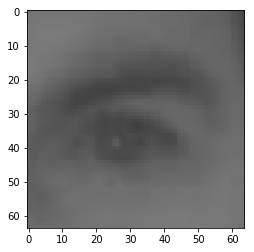

In [7]:
single_img = single_batch["image"][0]
plt.imshow(single_img.permute(1,2,0))

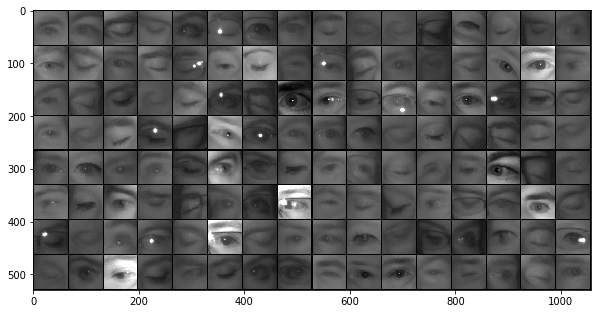

In [8]:
single_batch_grid = utils.make_grid(single_batch['image'], nrow=16)

plt.figure(figsize = (10,10))
plt.imshow(single_batch_grid.permute(1,2,0))

In [10]:
def conv_out_dims(hin,win,conv,pool=2):
    # Get Conv parameters
    kernel_size=conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        hout/=pool
        wout/=pool
        
    return int(hout),int(wout)

In [11]:
class Network(nn.Module):
    def __init__(self, params):
        super(Network, self).__init__()
        
        C_in, H_in, W_in = params['shape']
        init_f = params['initial_filters']
        num_fc1 = params['num_fc1']
        num_classes = params['num_classes']
        self.dropout_rate = params['dropout_rate']
        
        # Define CNN architecture
        self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3)
        h, w = conv_out_dims(H_in, W_in, self.conv1)
        
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h, w= conv_out_dims(h, w, self.conv2)
        
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h, w = conv_out_dims(h, w, self.conv3)
        
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h, w = conv_out_dims(h, w, self.conv4)
        
        # Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        
        # Hidden layers
        self.num_flatten = h*w*8*init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)
        
        # Special layers
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(self.dropout_rate)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,x):
        # CNN layers
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        
        # Flatten
        x = self.flatten(x)
        
        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        # Last activation function before output
        #out = self.sigmoid(x)
        out = x
        
        return out
        

# Neuronal networ parameters
params_model = {'shape': (3,64,64),
                'initial_filters': 8,
                'num_fc1': 100,
                'dropout_rate': 0.25,
                'num_classes': 1}

# Instantiate Network class
model = Network(params_model)
model = model.to(device)

In [12]:
L_RATE = 0.0001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = L_RATE)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, verbose=1)

In [13]:
def binary_acc(y_pred, y_test):
    correct_results = 0
    for i in range(len(y_pred)):
        temp = round(y_pred[i].item())
        if temp == y_test[i]:
            correct_results += 1
    
    return correct_results 

# Get learning rate from optimizer
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# Compute loss and metric over one batch
def loss_batch(loss_fn, output, target, opt=None):
    # Get loss
    loss = loss_fn(output, target)
    metric_b = binary_acc(output, target)
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    
    return loss.item(), metric_b
        
    
# Compute loss and metric over one epoch
def loss_epoch(model, loss_fn, data_ld, check=False, opt=None):
    run_loss = 0.0
    t_metric = 0.0
    len_data = len(data_ld.dataset)
    
    ## Internal Loop ##
    for sample in data_ld:
        data = sample['image'].to(device)
        label = sample['label'].to(device).type(torch.FloatTensor)
        
        # Forward Pass
        output = model(data)
        # Apply Sigmoid for training and validation
        sigmoid = nn.Sigmoid()
        output = sigmoid(output)
        
        loss_b, metric_b = loss_batch(loss_fn, output, label, opt) # Loss per batch
        run_loss += loss_b # Update running loss
        
        if metric_b is not None: # Update running metric
            t_metric += metric_b            
        
        # Break of the loop in case of sanity check
        if check:
            break
            
    loss = run_loss / float(len_data) # Avg. loss value
    metric = t_metric / float(len_data) # Avg. metric value
    
    return loss, metric
        

In [14]:
# Train the model
def fit(model, params, verbose=False):
    # Get training parameters
    epochs=params["epochs"]
    loss_fn=params["loss_fn"]
    opt=params["optimiser"]
    train_ld=params["train"]
    val_ld=params["val"]
    check=params["check"]
    lr_scheduler=params["lr_change"]
    weight_path=params["weight_path"]
    
    loss_history = {'train': [], 'val': []} # History of loss values each epoch
    metric_history = {'train': [], 'val': []} # History of metric values each epoch
    
    best_model_wts = copy.deepcopy(model.state_dict()) # Deep copy of the weights for best performing model
    best_loss = float('inf') # Initialize best loss to a large value
    
    ### MAIN LOOP ###
    for e in range(epochs):
        
        ### Get learning rate ###
        current_lr = get_lr(opt)
        if verbose:
            print('Epoch {e}/{epochs-1}, current lr={current_lr}')
            
        ### Train Model ###
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_fn, train_ld, check, opt)
        
        ### Collect loss and metric for the training set ###
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        ### Evaluate Model ###
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_fn, val_ld, check)
            
        ### Store best model ###
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # Store weights into local file
            torch.save(model.state_dict(), weight_path)
            if verbose:
                print('Copied best model weights in Epoch: ', e)
                
        ### Collect loss and metric for the validation set ###
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
                
        ### Learning rate scheduler ###
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if verbose:
                print('Loading best model weights!')
            model.load_state_dict(best_model_wts)
            
        if verbose:
            print(f'train loss: {train_loss:.6f}, val loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}')
            print('-'*10)
            
    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, loss_history, metric_history      
        

In [15]:
# Create Parameter Dictionary
params_train = {'train': train_loader,
                'val': val_loader,
                'epochs': 20,
                'optimiser': torch.optim.Adam(model.parameters(), lr = L_RATE),
                'lr_change': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.5, patience=20,verbose=0),
                'loss_fn': nn.BCELoss(),
                'weight_path': 'weights.pt',
                'check': True}

# Train and validate model with Sanity Check
model, loss_hist, metric_hist = fit(model, params_train)

C:\Users\usuario\.conda\envs\py3_6\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


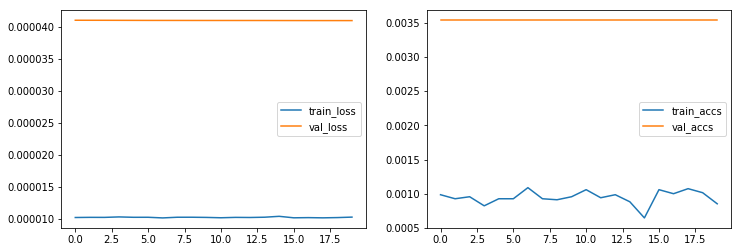

In [16]:
epochs = params_train['epochs']

fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(loss_hist['train'], label='train_loss')
plt.plot(loss_hist['val'], label='val_loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(metric_hist['train'], label='train_accs')
plt.plot(metric_hist['val'], label='val_accs')
plt.legend()
plt.show()

In [17]:
params_train = {'train': train_loader,
                'val': val_loader,
                'epochs': 50,
                'optimiser': torch.optim.Adam(model.parameters(), lr = L_RATE),
                'lr_change': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.5, patience=20,verbose=1),
                'loss_fn': nn.BCELoss(),
                'weight_path': 'weights_eye.pt',
                'check': False}

# Train and validate model after Sanity Check
model, loss_hist, metric_hist = fit(model, params_train)

C:\Users\usuario\.conda\envs\py3_6\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([78])) that is different to the input size (torch.Size([78, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
C:\Users\usuario\.conda\envs\py3_6\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([84])) that is different to the input size (torch.Size([84, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


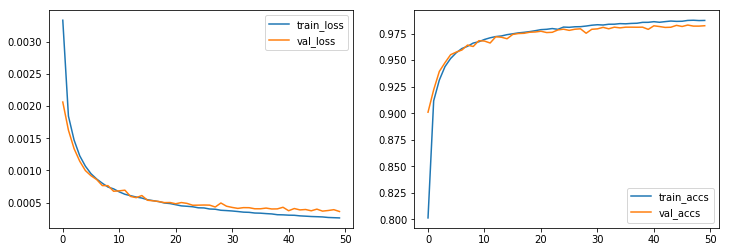

In [18]:
epochs = params_train['epochs']

fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(loss_hist['train'], label='train_loss')
plt.plot(loss_hist['val'], label='val_loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(metric_hist['train'], label='train_accs')
plt.plot(metric_hist['val'], label='val_accs')
plt.legend()
plt.show()